## To do:
* monthly mean vs daily
* detrend data compare
* remove offset from climate projections
* check resolution


In [47]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import run
import func
from scipy.signal import detrend

## Get data

In [2]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])


In [3]:
# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [4]:
np.shape(P_data)

(8766, 22, 22)

In [5]:
gridcells =[]
for lat in range(len(P_data.lat)):
        for lon in range(len(P_data.lon)):
                if np.isnan(lai_data[:, lat, lon]).all():
                    gridcells.append((lat,lon))

In [6]:
len(gridcells)

37

In [7]:
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        if np.isnan(lai_data[:, lat, lon]).all():
            continue
        else:
            # Get the data for the current grid cell
            grid_cell_data = lai_data[:, lat, lon]
            
            # Convert to DataFrame for easier handling
            grid_cell_df = pd.DataFrame(grid_cell_data)
            
            # Fill NA values with the previous value
            grid_cell_df.fillna(method='ffill', inplace=True)
            
            # Update the grid cell data
            lai_data[:, lat, lon] = grid_cell_df.values.flatten()

C:\Users\motze\AppData\Local\Temp\ipykernel_11276\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_11276\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_11276\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_11276\3542156106.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method

In [53]:
# Fill LAI with zeros were Na :D (wrong)
#lai_data = lai_data.fillna(0)

## Run model for daily values

In [8]:
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]

In [16]:
output_daily = func.grid_model(P_data, R_data, T_data, lai_data, params, cell = False)

Removed grid cell: 0 0


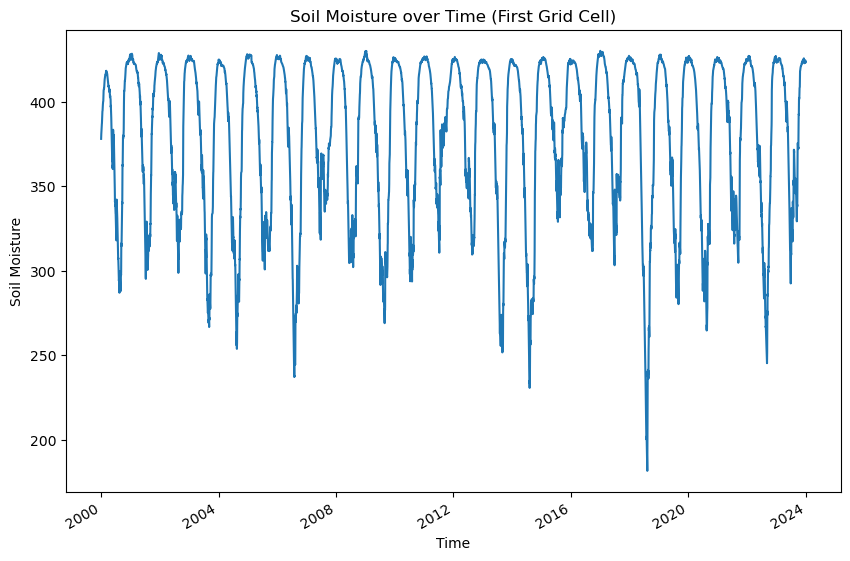

In [9]:
plt.figure(figsize=(10, 6))
output_daily['soil_moisture'].isel(lat=0, lon=0).plot(x='time')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture over Time (First Grid Cell)')
plt.show()

## Run model on monthly data

In [20]:
new_time_range = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')
lai_data['time'] = new_time_range

In [21]:
# Calculate monthly means
P_monthly = P_data.resample(time='1M').mean(dim='time')
R_monthly = R_data.resample(time='1M').mean(dim='time')
T_monthly = T_data.resample(time='1M').mean(dim='time')
lai_monthly = lai_data.resample(time='1M').mean(dim='time')

In [59]:
output_monthly = func.grid_model(P_monthly, R_monthly, T_monthly, lai_monthly, params, cell = True)

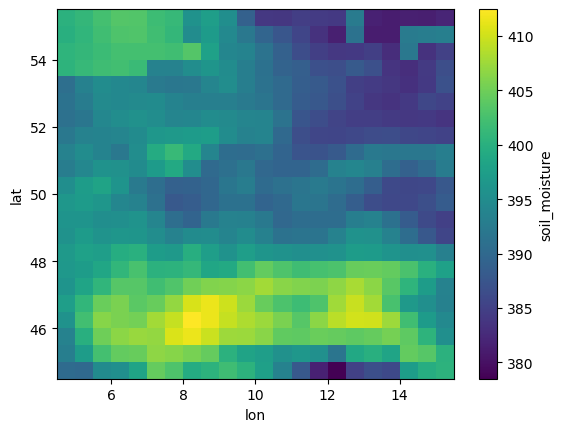

In [61]:
output_monthly['soil_moisture'].max(dim='time').plot()

In [66]:
# Save as csv
#output_monthly_df = output_monthly.to_dataframe()
#output_monthly_df.to_csv("results/monthly_lai_0.csv")

## Run model only for certain gridcells

In [9]:
# gridcells to look at
grid = [(4,4),(4,18),(18,4),(18,18)]

In [10]:
# run model
output = func.grid_model_cell(P_data, R_data, T_data, lai_data, params, cells = grid)

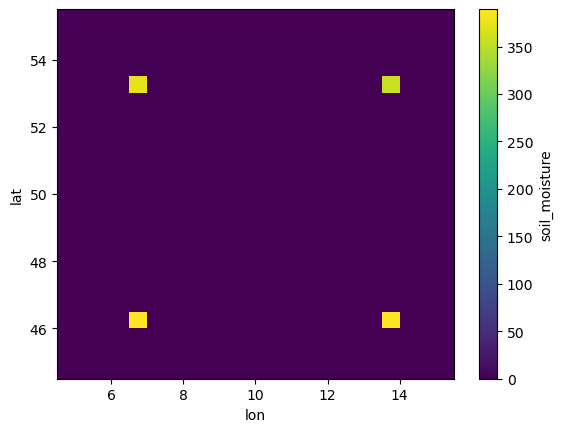

In [23]:
output['soil_moisture'].mean(dim='time').plot()

## Detrend data

In [51]:
T_data_detrend = func.rem_trend(T_data)

AttributeError: module 'func' has no attribute 'rem_trend'

In [61]:
# Convert temperature data to numpy array
temperature_array = T_data.values

# Reshape the data into 2D array (time, flattened spatial dimensions)
time_length = len(T_data.time)
spatial_dims = T_data.shape[1:]
temperature_2d = temperature_array.reshape((time_length, -1))


def remove_linear_trend(data):
    # Detrend the data to remove the linear trend
    detrended_data = detrend(data, axis=0, type='linear')
    
    # Calculate the mean of the original data
    mean_data = np.mean(data, axis=0)
    
    # Add back the mean to the detrended data
    detrended_data_with_mean = detrended_data + mean_data
    
    return detrended_data_with_mean

# Applying detrending function
detrended_temperature = remove_linear_trend(temperature_2d)

# Reshape detrended data back to its original shape
T_data_detrend = xr.DataArray(detrended_temperature.reshape((time_length,) + spatial_dims),
                                          coords=T_data.coords, dims=T_data.dims)

In [59]:
R_data_detrend = func.rem_trend(R_data)

AttributeError: module 'func' has no attribute 'rem_trend'

### Run model with detrended data

In [64]:
# Run model with detrended data
output_detrend = func.grid_model_cell(P_data, R_data_detrend, 
                                      T_data_detrend, lai_data, 
                                      params, cells = grid)

## Compare

In [70]:
# Calculate the difference to get the trend
difference_data = output - output_detrend

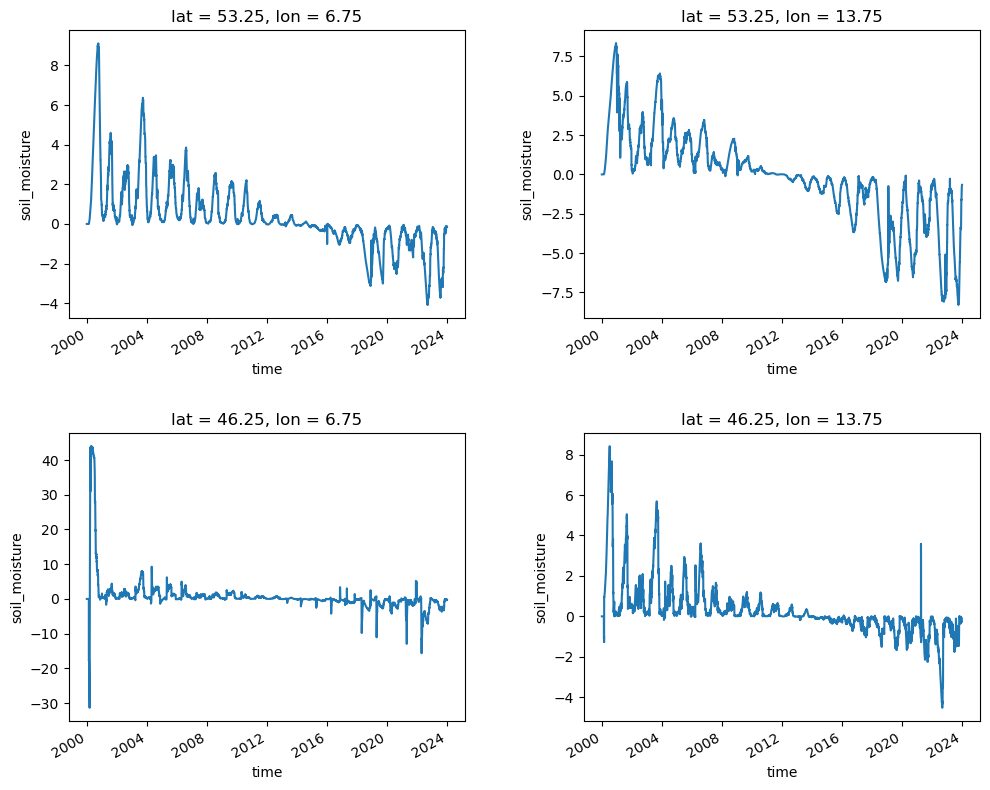

In [107]:
plot_func(difference_data, grid,'soil_moisture')

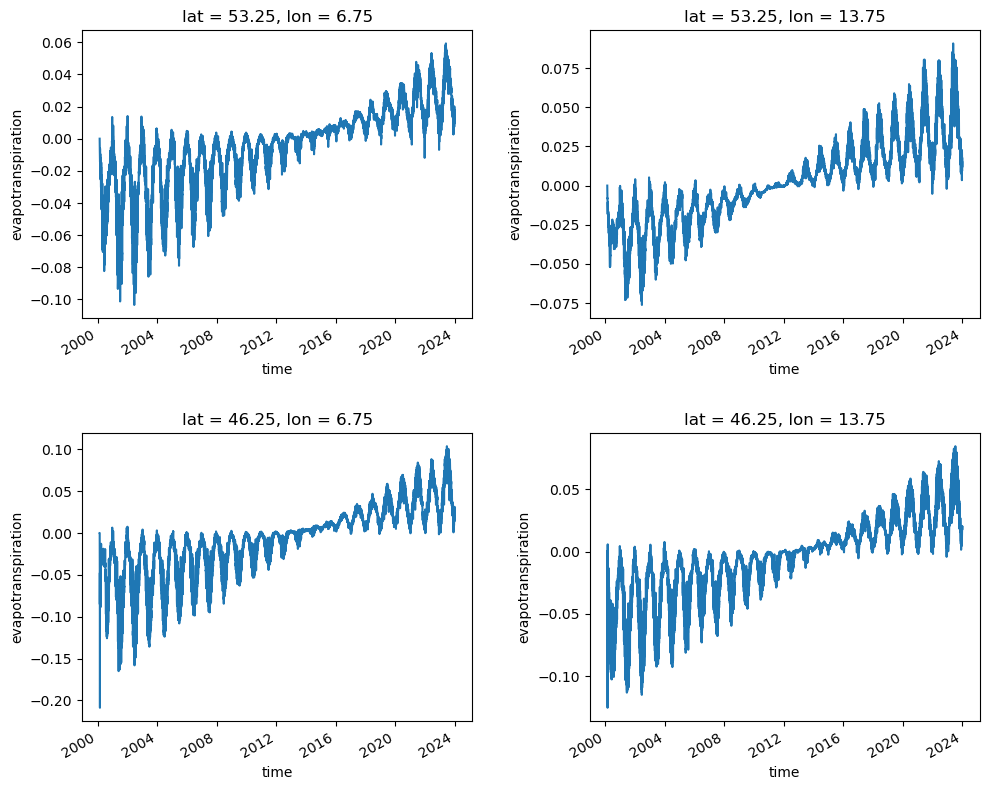

In [106]:
plot_func(difference_data, grid,'evapotranspiration')

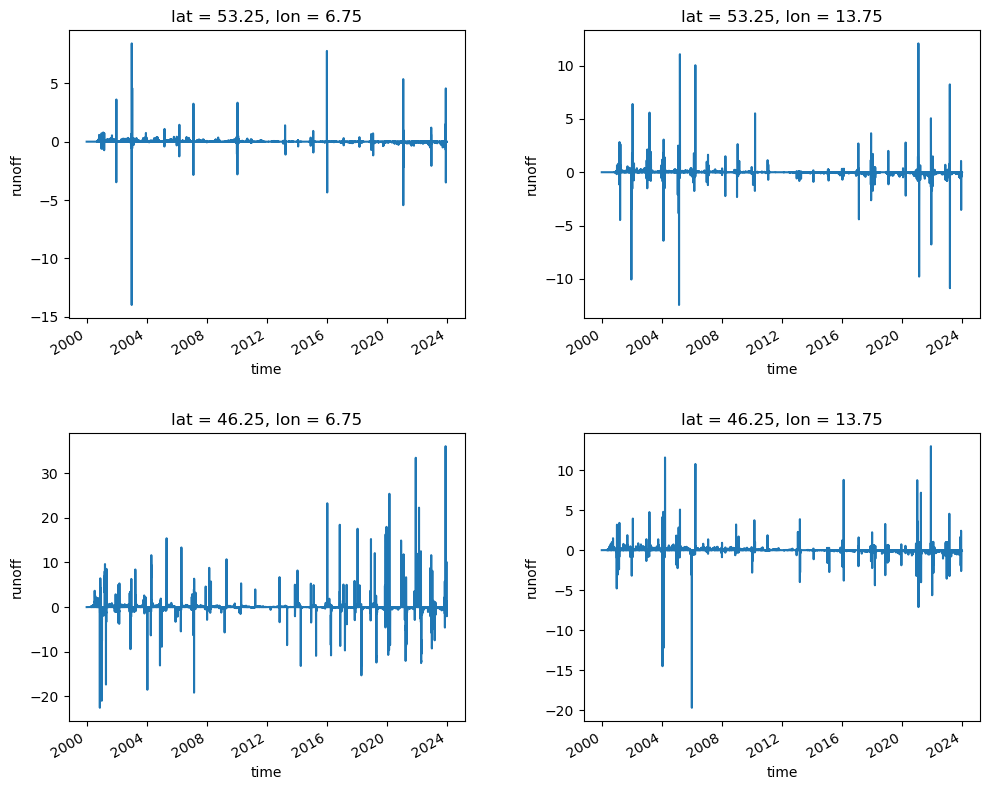

In [105]:
plot_func(difference_data, grid,'runoff')

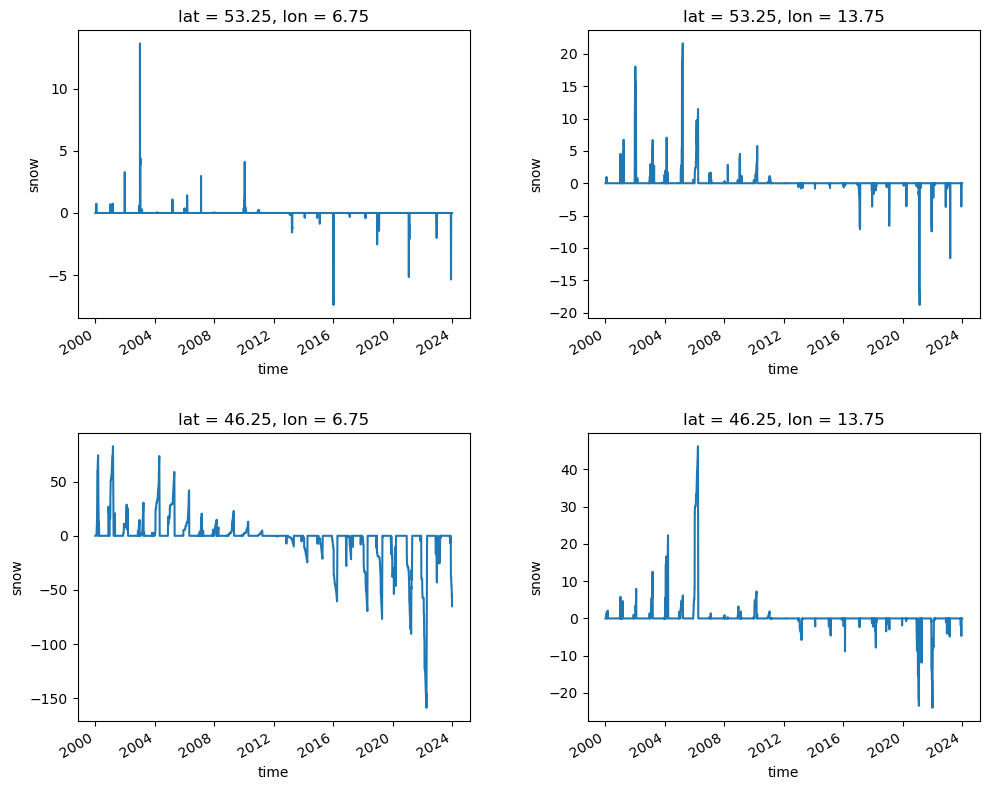

In [104]:
plot_func(difference_data, grid,'snow')